In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import scipy.optimize as optimize

import Bargaining as brg

do_cpp = True
do_compile = True

In [2]:
# compile c++ files
if do_cpp & do_compile:
    model = brg.HouseholdModelClass(par={'do_cpp':do_cpp})
    model.link_to_cpp(force_compile=do_compile)

# Solve and simulate from alternative models

In [3]:
# settings for models to solve
T = 10
specs = {
    'model 1':{'latexname':'$\sigma_{\psi}=0$', 'par':{'sigma_love':0.0,'T':T,'do_cpp':do_cpp}},
    'model 2':{'latexname':'$\sigma_{\psi}=0.01$', 'par':{'sigma_love':0.01,'T':T,'do_cpp':do_cpp}},
    'model 3':{'latexname':'$\sigma_{\psi}=0.05$', 'par':{'sigma_love':0.05,'T':T,'do_cpp':do_cpp}},
    'model 4':{'latexname':'$\sigma_{\psi}=0.1$', 'par':{'sigma_love':0.1,'T':T,'do_cpp':do_cpp}},
}

In [4]:
# solve and simulate from models
models = {}
for name,spec in specs.items():
    print(f'solving and simulating {name}...')
    # setup model
    models[name] = brg.HouseholdModelClass(name=name,par=spec['par'])
    if do_cpp: models[name].link_to_cpp(force_compile=False)
    models[name].spec = spec
    
    # solve
    models[name].solve()
    
    # simulate
    models[name].simulate()

solving and simulating model 1...
solving and simulating model 2...
solving and simulating model 3...
solving and simulating model 4...


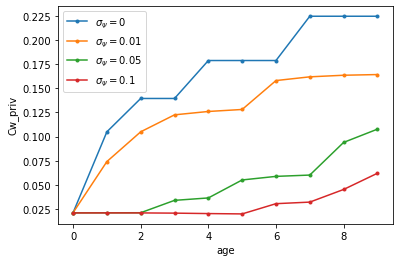

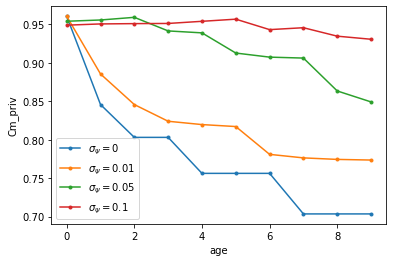

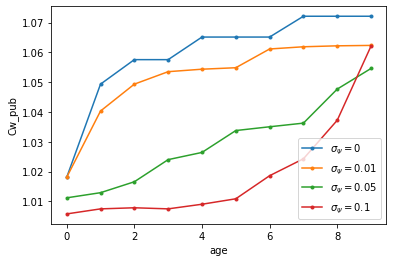

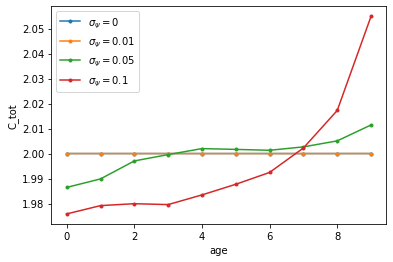

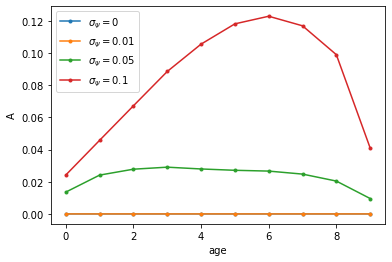

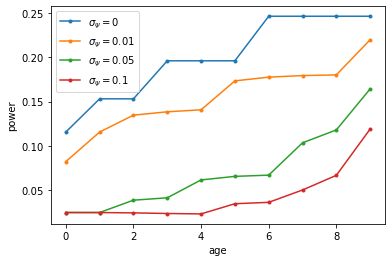

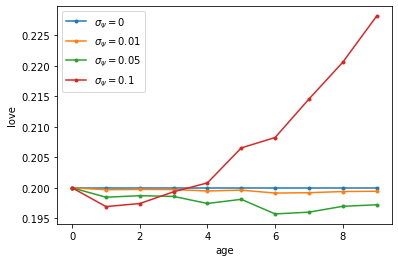

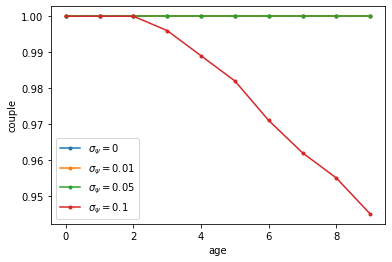

In [5]:
init_power_idx = 1
init_love = 0.2 # interesting difference: 0.0 vs 0.2   [with sigma_love=0.0]

for var in ('Cw_priv','Cm_priv','Cw_pub','C_tot','A','power','love','couple'):

    fig, ax = plt.subplots()

    for name in specs.keys():
        model = models[name]

        # show how starting of in a low bargaining power gradually improves
        model.sim.init_power_idx[:] = init_power_idx
        model.sim.init_love[:] = init_love 
        model.simulate()
        
        # pick out couples (if not the share of couples is plotted)
        if var == 'couple':
            nan = 0.0
        else:
            I = model.sim.couple<1
            nan = np.zeros(I.shape)
            nan[I] = np.nan
        
        # pick relevant varialbe relevant variable for couples
        y = getattr(model.sim,var)        
        y = np.nanmean(y + nan,axis=0)

        ax.plot(y,marker='.',label=model.spec['latexname']);
        ax.set(xlabel='age',ylabel=f'{var}');
        
    plt.legend()

In [6]:
stop

NameError: name 'stop' is not defined

# Plot optimal behavior in alternative models 

In [ ]:
# TODO: 
# 1. check when parameters change..
# WHY ARE THEY NOT OVERLAPPING when sigma_love=0.1!!? I think it must have to do with the very steep slope in the bottom and the grid spacing
# yes: that is why

sol = model.sol
par = model.par
t =  0 #0 #par.T-1 - 1 
iL = 5 # for negative shocks (iL<5), the relationship is doomed..

for iA in [0,10,30]:
    plt.plot(par.grid_power,sol.Vw_couple[t,:,iL,iA]);
    plt.plot(par.grid_power,np.ones(par.grid_power.size)*sol.Vw_single[t,iA]); # the slight difference is from the discrete power grid
    
#     plt.plot(par.grid_power,par.grid_power[sol.power_idx[t,:,iL,iA]],marker='.')
#     plt.plot(par.grid_power,par.grid_power,linestyle='--')

In [ ]:


t = par.T-4
iL = 5
X, Y = np.meshgrid(par.grid_power, par.grid_A,indexing='ij')

for var in ('Vw_couple','Vm_couple','Cw_priv_couple','Cm_priv_couple','C_pub_couple','power'):

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    if var == 'power':
        power_idx = sol.power_idx[t,:,iL,:]
        Z = par.grid_power[power_idx] # if negative-> divorce. Then this wouldn't work
        
        Z[power_idx<0] = -9210.
    else:
        Z = getattr(sol,var)[t,:,iL,:]

    ax.plot_surface(X, Y, Z,rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none');
    ax.set(xlabel='power (woman)',ylabel='wealth',title=f'{var}');

In [ ]:
# plot as a function of love and wealth
t = par.T-4
iP = 10
X, Y = np.meshgrid(par.grid_love, par.grid_A,indexing='ij')

for var in ('Vw_couple','Vm_couple','Cw_priv_couple','Cm_priv_couple','C_pub_couple','power'):

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    if var == 'power':
        power_idx = sol.power_idx[t,iP,:,:]
        Z = par.grid_power[power_idx] # if negative-> divorce. Then this wouldn't work
        
        Z[power_idx<0] = -9210.
    else:
        Z = getattr(sol,var)[t,iP,:,:]

    ax.plot_surface(X, Y, Z,rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none');
    ax.set(xlabel='love',ylabel='wealth',title=f'{var}');

In [ ]:
# plot as a function of power and love 
t = par.T-4
iA = 10
X, Y = np.meshgrid(par.grid_power, par.grid_love,indexing='ij')

for var in ('Vw_couple','Vm_couple','Cw_priv_couple','Cm_priv_couple','C_pub_couple','power'):

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    if var == 'power':
        power_idx = sol.power_idx[t,:,:,iA]
        Z = par.grid_power[power_idx] # if negative-> divorce. Then this wouldn't work
        
        Z[power_idx<0] = -9210.
    else:
        Z = getattr(sol,var)[t,:,:,iA]

    ax.plot_surface(X, Y, Z,rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none');
    ax.set(xlabel='power',ylabel='love',title=f'{var}');

In [ ]:
# %lprun -f model.value_of_choice_couple -f brg.util -f model.indiv_value_of_choice_couple model.solve()

In [ ]:
model_name = 'model 1'
model = models[model_name]

# show how starting of in a low bargaining power gradually improves
model.sim.init_power_idx[:] = 1
model.sim.init_love[:] = 0.2 # interesting difference: 0.0 vs 0.2   [with sigma_love=0.0]
model.simulate()

for var in ('Cw_priv','Cm_priv','Cw_pub','C_tot','A','power','love','couple'):

    fig, ax = plt.subplots()
    
    if var == 'C_tot':
        C_tot = model.sim.Cw_priv + model.sim.Cm_priv + model.sim.Cw_pub
        y = np.nanmean(C_tot,axis=0)
    else:
        y = np.nanmean(getattr(model.sim,var),axis=0)

    ax.plot(y,marker='.');
    ax.set(xlabel='age',ylabel=f'{var}');